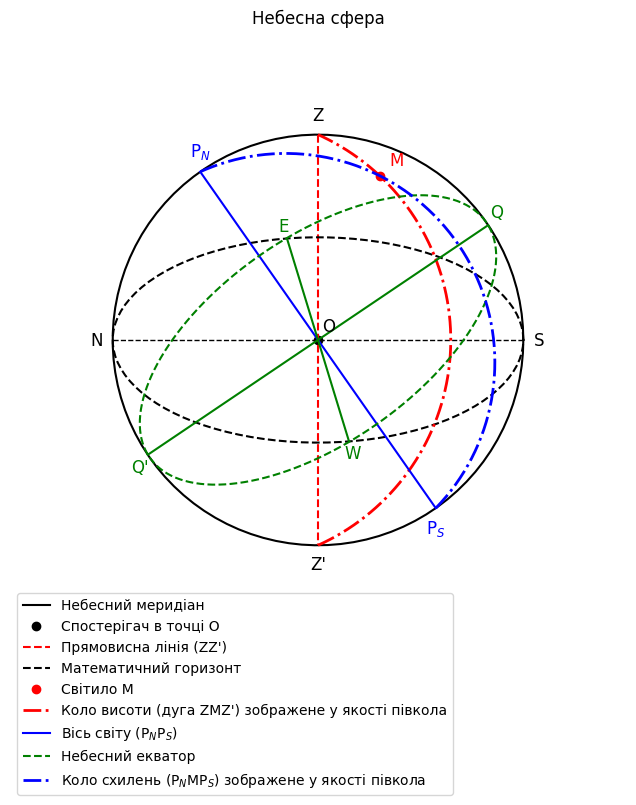

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def circle_from_3pts(p1, p2, p3):
    """
    Повертає (cx, cy, r) – координати центру (cx, cy) та радіус r кола,
    що проходить через точки p1, p2, p3.
    Якщо точки (майже) колінеарні, повертає (None, None, None).
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    
    A = x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2)
    if abs(A) < 1e-12:
        return None, None, None
    
    b1 = x1**2 + y1**2
    b2 = x2**2 + y2**2
    b3 = x3**2 + y3**2
    
    cx = 0.5 * ( b1*(y2 - y3) + b2*(y3 - y1) + b3*(y1 - y2) ) / A
    cy = 0.5 * ( b1*(x3 - x2) + b2*(x1 - x3) + b3*(x2 - x1) ) / A
    
    r = np.sqrt((x1 - cx)**2 + (y1 - cy)**2)
    return cx, cy, r

def normalize_angle(a):
    """ Зводить кут a до інтервалу [0, 2*pi). """
    return a % (2*np.pi)

def asc_arc(a1, a2, steps=300):
    """
    Повертає відмасштабований масив кутів від a1 до a2,
    рухаючись за зростанням (підтримує перехід через 2*pi).
    """
    a1n = normalize_angle(a1)
    a2n = normalize_angle(a2)
    if a2n < a1n:
        a2n += 2*np.pi
    return np.linspace(a1n, a2n, steps)

def arc_from_3pts(Z, M, Zp):
    """
    Повертає масив кутів (у [cx, cy]-системі) для тієї дуги,
    яка іде від двох опорних точок небесної сфери і включає M.
    
    Алгоритм:
    1) Шукаємо центр і радіус кола через (Z, M, Z').
    2) Обчислюємо кути aZ, aM, aZp у полярних координатах відносно центру (cx, cy).
    3) Формуємо дві можливі дуги:
       - arc1: від aZ до aZp (за зростанням)
       - arc2: від aZp до aZ (за зростанням)
    4) Перевіряємо, в якій із цих дуг лежить aM.
    5) Повертаємо ту дугу, де aM «між» aZ та aZp.
    """
    cx, cy, r = circle_from_3pts(Z, M, Zp)
    if cx is None:
        # Якщо коло не визначено (точки колінеарні) – повертаємо порожній масив
        return [], None, None
    
    def angle(p):
        return np.arctan2(p[1] - cy, p[0] - cx)
    
    aZ  = angle(Z)
    aM  = angle(M)
    aZp = angle(Zp)
    
    arc1 = asc_arc(aZ, aZp)
    arc2 = asc_arc(aZp, aZ)
    
    aMnorm = normalize_angle(aM)
    
    def angle_in_arc(a, arc):
        return (arc[0] <= a <= arc[-1])
    
    if angle_in_arc(aMnorm, arc1):
        return arc1, cx, cy
    else:
        return arc2, cx, cy

# ----------------------------------------------------
# Основний код побудови

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, aspect='equal')

# Parameters for the circle
center = (0, 0)    # Center of the circle (x, y)
radius = 1         # Radius of the circle

# Create an array of angles from 0 to 2pi
theta = np.linspace(0, 2 * np.pi, 100)

# Compute x and y coordinates of the circle
x = center[0] + radius * np.cos(theta)
y = center[1] + radius * np.sin(theta)

ax.plot(x, y, color='black', linewidth=1.5, label="Небесний меридіан")


# Небесна сфера (коло радіуса 1)
# sphere = plt.Circle((0, 0), 1, edgecolor="black", facecolor="none", linewidth=1.5)
# ax.add_artist(sphere)

# Спостерігач у центрі
ax.plot(0, 0, 'o', color="black", label="Спостерігач в точці O")
# Додамо символьне позначення "O" біля центру
ax.text(0.02, 0.02, "O", fontsize=12, ha='left', va='bottom', color='black')

# Екватор (зараз – це лінія x-ось)
ax.plot([-1, 1], [0, 0], linestyle="--", color="black", linewidth=1)

# Зеніт і надир
Z = (0, 1)
Zp = (0, -1)
ax.text(0, 1.05, "Z", ha='center', va='bottom', fontsize=12)
ax.text(0, -1.05, "Z'", ha='center', va='top', fontsize=12)

# Прямовисна лінія Z–Z'
ax.plot([0, 0], [1, -1], linestyle="--", color="red", linewidth=1.5,
        label="Прямовисна лінія (ZZ')")

# Кардинальні точки N і S
ax.text(-1.05, 0, "N", ha='right', va='center', fontsize=12)
ax.text(1.05, 0, "S", ha='left', va='center', fontsize=12)

# Математичний горизонт (еліпс)
theta = np.linspace(0, 2 * np.pi, 100)
horizon_x = np.cos(theta)
horizon_y = 0.5 * np.sin(theta)
ax.plot(horizon_x, horizon_y, color="black", linestyle="--", label="Математичний горизонт")

# Приклад розташування світила M
M = (0.3, 0.8)  # десь у 1-му квадранті
ax.plot(M[0], M[1], 'ro', label="Світило M")
ax.text(M[0]+0.05, M[1]+0.05, "M", color="red", fontsize=12)

# "Вертикаль" (коло, що проходить через Z, M, Z'), але будуємо лише дугу
arc, cx, cy = arc_from_3pts(Z, M, Zp)
if len(arc) > 0 and cx is not None:
    r = np.sqrt((Z[0] - cx)**2 + (Z[1] - cy)**2)
    x_arc = cx + r * np.cos(arc)
    y_arc = cy + r * np.sin(arc)
    ax.plot(x_arc, y_arc, linestyle="-.", color="red", linewidth=2,
            label="Коло висоти (дуга ZMZ') зображене у якості півкола")

# Вісь світу (для прикладу – нахилена на 35° від вертикалі)
alpha_deg = 35
alpha = np.radians(alpha_deg)
PN = (-np.sin(alpha), np.cos(alpha))
PS = ( np.sin(alpha),-np.cos(alpha))

ax.plot([PN[0], PS[0]], [PN[1], PS[1]], color="blue", linewidth=1.5,
        label="Вісь світу (P$_N$P$_S$)")
ax.text(PN[0], PN[1]+0.05, "P$_N$", color="blue", ha='center', va='bottom', fontsize=12)
ax.text(PS[0], PS[1]-0.05, "P$_S$", color="blue", ha='center', va='top',   fontsize=12)

# ---------------------------------------------------------------------
# 1) Небесний екватор – велике коло перпендикулярне осі P_NP_S.
# У 3D це було б просто коло на сфері, тут відмалюємо його як еліпс,
# аналогічно до "математичного горизонту", але повернутий на кут alpha.

theta_eq = np.linspace(0, 2*np.pi, 300)
# Задамо базовий "еліпс" (радіуси 1 і 0.5) і повернемо на кут alpha.
# Якщо потрібно інше "співвідношення осей", можна змінити коефіцієнт 0.5.
eq_base_x = np.cos(theta_eq)
eq_base_y = 0.5 * np.sin(theta_eq)

# Матриця обертання на кут alpha:
# [ cos(alpha) -sin(alpha)
#   sin(alpha)  cos(alpha) ]
# Припустимо, що цей кут відповідає нахилу від вертикалі
# (самі можна підлаштувати знак «-» чи «+» для бажаної візуалізації).
eq_x = eq_base_x*np.cos(alpha) - eq_base_y*np.sin(alpha)
eq_y = eq_base_x*np.sin(alpha) + eq_base_y*np.cos(alpha)

ax.plot(eq_x, eq_y, color="green", linestyle="--", linewidth=1.5,
        label="Небесний екватор")

# 2) Коло схилень світила (P_N M P_S)
# Використовуємо ту ж arc_from_3pts, але тепер для (P_N, M, P_S).
arc_decl, cxd, cyd = arc_from_3pts(PN, M, PS)
if len(arc_decl) > 0 and cxd is not None:
    r_decl = np.sqrt((PN[0] - cxd)**2 + (PN[1] - cyd)**2)
    x_decl = cxd + r_decl * np.cos(arc_decl)
    y_decl = cyd + r_decl * np.sin(arc_decl)
    ax.plot(x_decl, y_decl, linestyle="-.", color="blue", linewidth=2,
            label="Коло схилень (P$_N$MP$_S$) зображене у якості півкола")

beta_deg = 56
beta = np.radians(beta_deg)
Q1 = (np.sin(beta), np.cos(beta))
Q2 = ( -np.sin(beta),-np.cos(beta))

ax.plot([Q1[0], Q2[0]], [Q1[1], Q2[1]], color="green", linewidth=1.5)
ax.text(Q1[0]+0.04, Q1[1]+0.02, "Q", color="green", ha='center', va='bottom', fontsize=12)
ax.text(Q2[0]-0.04, Q2[1]-0.02, "Q'", color="green", ha='center', va='top',   fontsize=12)

gamma_deg = 17
gamma = np.radians(gamma_deg)
coeff = 0.51
E_point = (-np.sin(gamma) * coeff, np.cos(gamma) * coeff)
W_point = ( np.sin(gamma) * coeff,-np.cos(gamma) * coeff)

ax.plot([E_point[0], W_point[0]], [E_point[1], W_point[1]], color="green", linewidth=1.5)
ax.text(E_point[0]-0.02, E_point[1]+0.02, "E", color="green", ha='center', va='bottom', fontsize=12)
ax.text(W_point[0]+0.02, W_point[1]-0.02, "W", color="green", ha='center', va='top',   fontsize=12)

# ---------------------------------------------------------------------

# Оформлення
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.axis("off")

plt.legend(loc="lower left", bbox_to_anchor=(0, -0.25))
plt.title("Небесна сфера")

plt.savefig("celestial_sphere_2.png", format="png", dpi=300, bbox_inches="tight")

plt.show()


In [32]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# ========================================================================
# Допоміжні функції
# ========================================================================

def normalize(v):
    """Нормує вектор v до довжини 1."""
    return v / np.linalg.norm(v)

def param_sphere(num_phi=30, num_theta=60):
    """
    Повертає сітки (X, Y, Z) для відмалювання сфери радіуса 1.
    phi – полярний кут від 0 до pi,
    theta – азимутальний кут від 0 до 2*pi.
    """
    phi = np.linspace(0, np.pi, num_phi)
    theta = np.linspace(0, 2*np.pi, num_theta)
    phi, theta = np.meshgrid(phi, theta)
    
    X = np.sin(phi) * np.cos(theta)
    Y = np.sin(phi) * np.sin(theta)
    Z = np.cos(phi)
    return X, Y, Z

def circle_on_sphere(normal, steps=100):
    """
    Повертає координати (x, y, z) великого кола на сфері,
    яке лежить у площині, перпендикулярній до normal, і проходить через (0,0,0).
    (normal має бути нормований).
    """
    # Знайдемо будь-які два взаємно перпендикулярні вектори u, v у площині кола
    # (тобто вони перпендикулярні до normal).
    # Найпростіше – взяти довільний вектор, перетнути з normal, і ще раз перетнути з normal.
    # Але простіше зафіксувати "eZ = (0,0,1)", якщо воно не вироджене до normal.
    
    # Якщо normal (майже) колінеарний до (0,0,1), то можна взяти іншу "базу".
    # Тут для наочності зробимо універсальний підхід.
    
    # Умовно візьмемо eX = (1,0,0) і eY = (0,1,0), eZ = (0,0,1)
    # і дивитимемось, з яким вектором normal найменше колінеарна.
    cand = [
        np.array([1,0,0]),
        np.array([0,1,0]),
        np.array([0,0,1])
    ]
    # Знайдемо вектор, який найменше паралельний до normal (через косинус кута)
    dotvals = [abs(np.dot(normal, c)) for c in cand]
    e = cand[np.argmin(dotvals)]
    
    # Будуємо базис у площині
    u = np.cross(normal, e)
    u = normalize(u)
    v = np.cross(normal, u)
    v = normalize(v)
    
    # Випараметризуємо коло: X(t) = u*cos(t) + v*sin(t)
    t = np.linspace(0, 2*np.pi, steps)
    circle_x = []
    circle_y = []
    circle_z = []
    for ang in t:
        point = np.cos(ang)*u + np.sin(ang)*v
        circle_x.append(point[0])
        circle_y.append(point[1])
        circle_z.append(point[2])
    return np.array(circle_x), np.array(circle_y), np.array(circle_z)

def circle_through_3pts(p1, p2, p3, steps=200):
    """
    Для трьох точок на сфері (p1, p2, p3) будуємо коло (або "велике/мале коло"),
    що проходить через ці три точки (якщо вони не колінеарні).
    
    Повертає (x_arc, y_arc, z_arc) – дугу на сфері, яка іде від p1 до p3
    через p2 (тобто та частина кола, де p2 "лежить між" p1 та p3").
    
    Ідея аналогічна вашій arc_from_3pts, але тепер у 3D:
    1) Знаходимо площину, що проходить через p1, p2, p3 (через 0,0,0, якщо вважаємо сферу у центрі).
       – Оскільки O=(0,0,0) теж у центрі сфери, припустимо, що p1, p2, p3 лежать на сфері радіуса 1.
    2) Визначаємо вектор normal = (p1 x p2) + (p2 x p3) + (p3 x p1) (або простіше: p1 x p2 + ...),
       щоб отримати "напрям" площини, у якій лежить коло.
    3) Параметризуємо коло (intersection plane & sphere).
    4) Визначаємо дві можливі дуги (бо коло – повне). Вибираємо ту, де p2 лежить "посередині".
    """
    # Перевіримо, чи не колінеарні (або майже) p1, p2, p3.
    # Якщо площа трикутника дуже мала – повертаємо порожній результат.
    # Площа ~ ||(p2 - p1) x (p3 - p1)|| / 2
    area = np.linalg.norm(np.cross(p2 - p1, p3 - p1)) / 2
    if area < 1e-12:
        return np.array([]), np.array([]), np.array([])
    
    # Нормальний вектор до площини, що проходить через p1,p2,p3
    # (і через (0,0,0), якщо точки на сфері).
    # Точніше, normal визначимо як cross(p1, p2) + cross(p2, p3) + cross(p3, p1)
    # Це забезпечить орієнтацію, яка "захоплює" всі три точки. Але можна й простіше:
    plane_normal = np.cross(p1, p2) + np.cross(p2, p3) + np.cross(p3, p1)
    plane_normal = normalize(plane_normal)
    
    # Повне коло у цій площині
    cx, cy, cz = circle_on_sphere(plane_normal, steps=4*steps)  # щоб арка була плавніша
    
    # Тепер треба знайти, де на цьому колі лежать p1, p2, p3 (кути).
    # У параметризації кола X(t)=u cos(t)+v sin(t) ми заздалегідь не зберігали t,
    # тож зробимо простіше: знайдемо найближчі індекси до p1, p2, p3.
    
    # Допоміжна функція для пошуку найближчої точки
    def find_nearest_idx(xarr, yarr, zarr, p):
        # мінімізуємо відстань ||(x_i,y_i,z_i) - p||
        dist = (xarr - p[0])**2 + (yarr - p[1])**2 + (zarr - p[2])**2
        return np.argmin(dist)
    
    i1 = find_nearest_idx(cx, cy, cz, p1)
    i2 = find_nearest_idx(cx, cy, cz, p2)
    i3 = find_nearest_idx(cx, cy, cz, p3)
    
    # Кожна пара (i1,i3) задає дві дуги: прямий обхід і зворотний.
    # Подивимось, яка з них "містить" i2.
    n = len(cx)
    
    def arc_indices(i_start, i_end):
        """Повертає послідовність індексів від i_start до i_end (по модулю n)."""
        if i_end >= i_start:
            return np.arange(i_start, i_end+1)
        else:
            return np.concatenate([np.arange(i_start, n), np.arange(0, i_end+1)])
    
    arc1 = arc_indices(i1, i3)
    arc2 = arc_indices(i3, i1)
    
    # Перевіряємо, де лежить i2
    def in_arc(i2, arc):
        return i2 in arc
    
    if in_arc(i2, arc1):
        arc_idx = arc1
    else:
        arc_idx = arc2
    
    return cx[arc_idx], cy[arc_idx], cz[arc_idx]

# ========================================================================
# Основна побудова 3D
# ========================================================================

# Створюємо фігуру
fig = make_subplots(rows=1, cols=1,
                    specs=[[{'type':'scatter3d'}]],
                    subplot_titles=["Небесна сфера в 3D"])

# 1) Небесна сфера як поверхня
Xs, Ys, Zs = param_sphere()
sphere_surface = go.Surface(
    x = Xs, y = Ys, z = Zs,
    colorscale='Blues',
    opacity=0.3,
    showscale=False,
    name='Celestial Sphere'
)
fig.add_trace(sphere_surface, row=1, col=1)

# 2) Точки та лінії
data_traces = []

# --- Спостерігач у центрі ---
O = np.array([0, 0, 0])
scatter_O = go.Scatter3d(
    x=[O[0]], y=[O[1]], z=[O[2]],
    mode='markers+text',
    text=["O"],
    textposition="middle left",
    marker=dict(size=5, color="black"),
    name="Спостерігач (O)"
)
data_traces.append(scatter_O)

# --- Z та Z' (вертикальна вісь) ---
Z = np.array([0,0,1])
Zp = np.array([0,0,-1])
scatter_ZZp = go.Scatter3d(
    x=[0,0], y=[0,0], z=[1,-1],
    mode='lines+markers+text',
    text=["Z", "Z'"],
    textposition=["bottom left","bottom center"],
    line=dict(color='red', width=3),
    marker=dict(size=4, color="red"),
    name="Прямовисна лінія (ZZ')"
)
data_traces.append(scatter_ZZp)

# --- Кардинальні точки N, S, E, W на площині z=0 ---
N = np.array([1,0,0])
S = np.array([-1,0,0])
E = np.array([0,-1,0])
W = np.array([0,1,0])

scatter_cardinals = go.Scatter3d(
    x=[N[0], S[0], E[0], W[0]],
    y=[N[1], S[1], E[1], W[1]],
    z=[N[2], S[2], E[2], W[2]],
    mode='markers+text',
    text=["N","S","E","W"],
    textposition=["middle right","middle left","bottom center","bottom center"],
    marker=dict(size=5, color="green"),
    name="Точка півночі (N), півдня (S), сходу (E), заходу (W)"
)
data_traces.append(scatter_cardinals)

# --- Горизонт (коло z=0 на сфері) ---
theta = np.linspace(0, 2*np.pi, 200)
horiz_x = np.cos(theta)
horiz_y = np.sin(theta)
horiz_z = np.zeros_like(theta)

scatter_horizon = go.Scatter3d(
    x=horiz_x, y=horiz_y, z=horiz_z,
    mode='lines',
    line=dict(color='black', dash='dash', width=2),
    name="Математичний горизонт (z=0)"
)
data_traces.append(scatter_horizon)

# --- Вісь світу P_N, P_S з нахилом alpha = 35° ---
alpha_deg = 35
alpha = np.radians(alpha_deg)

# Припустимо, що у "стандартному" положенні полюс був би (0,0,1).
# Тоді повернемо його навколо осі Y на кут alpha (змінюючи нахил у площині x-z).
Ry = np.array([
    [ np.cos(alpha), 0, np.sin(alpha)],
    [ 0,             1, 0            ],
    [-np.sin(alpha), 0, np.cos(alpha)]
])

PN = Ry.dot(np.array([0,0,1]))  # Північний полюс
PS = -PN                       # Південний полюс

scatter_axis = go.Scatter3d(
    x=[PN[0], PS[0]], y=[PN[1], PS[1]], z=[PN[2], PS[2]],
    mode='lines+markers+text',
    text=["P<sub>N</sub>", "P<sub>S</sub>"],
    textposition=["top center","bottom center"],
    line=dict(color='blue', width=3),
    marker=dict(size=4, color="blue"),
    name="Вісь світу"
)
data_traces.append(scatter_axis)

# --- Небесний екватор (велике коло перпендикулярне осі P_NP_S) ---
pn_normal = normalize(PN)  # це напрям осі
eq_x, eq_y, eq_z = circle_on_sphere(pn_normal)  # коло, перпендикулярне PN
scatter_equator = go.Scatter3d(
    x=eq_x, y=eq_y, z=eq_z,
    mode='lines',
    line=dict(color='green', dash='dash', width=3),
    name="Небесний екватор"
)
data_traces.append(scatter_equator)

# --- Приклад розташування світила M на сфері ---
# Нехай спочатку в 2D ви мали M=(0.3,0.8). У 3D додамо невеликий z і нормуємо:
M_init = np.array([0.4, 0.7, 0.5])
M = normalize(M_init)

scatter_M = go.Scatter3d(
    x=[M[0]], y=[M[1]], z=[M[2]],
    mode='markers+text',
    text=["M"],
    textposition="top center",
    marker=dict(size=5, color='red'),
    name="Світило (M)"
)
data_traces.append(scatter_M)

# --- "Вертикаль" (коло, що проходить через Z, M, Z') ---
v_x, v_y, v_z = circle_through_3pts(Z, M, Zp)
if len(v_x) > 0:
    scatter_vertical = go.Scatter3d(
        x=v_x, y=v_y, z=v_z,
        mode='lines',
        line=dict(color='red', width=3, dash='dot'),
        name="Коло висоти (ZMZ')"
    )
    data_traces.append(scatter_vertical)

# --- Коло схилень (через P_N, M, P_S) ---
d_x, d_y, d_z = circle_through_3pts(PN, M, PS)
if len(d_x) > 0:
    scatter_decl = go.Scatter3d(
        x=d_x, y=d_y, z=d_z,
        mode='lines',
        line=dict(color='blue', width=3, dash='dot'),
        name="Коло схилень (P<sub>N</sub>MP<sub>S</sub>)"
    )
    data_traces.append(scatter_decl)

# --- Небесний меридіан (через Z, Z' та полюси світу P_N, P_S)
# Обираємо Z та P_N для визначення площини меридіану.
merid_plane_normal = normalize(np.cross(Z, PN))
merid_x, merid_y, merid_z = circle_on_sphere(merid_plane_normal, steps=200)
scatter_meridian = go.Scatter3d(
    x=merid_x, y=merid_y, z=merid_z,
    mode='lines',
    line=dict(color='black', width=3),
    name="Небесний меридіан"
)
data_traces.append(scatter_meridian)

# Додаємо всі лінії/точки до фігури
for tr in data_traces:
    fig.add_trace(tr, row=1, col=1)

# Налаштування 3D-сцени
fig.update_layout(
    # title="Небесна сфера в 3D",
    scene=dict(
        xaxis=dict(
            range=[-1.5, 1.5], 
            showgrid=False, zeroline=False, visible=False
        ),
        yaxis=dict(
            range=[-1.5, 1.5], 
            showgrid=False, zeroline=False, visible=False
        ),
        zaxis=dict(
            range=[-1.5, 1.5], 
            showgrid=False, zeroline=False, visible=False
        ),
        aspectmode='cube',
        camera=dict(
            eye=dict(x=0.8, y=0.5, z=0.3)
        ),
    ),
    showlegend=True,
    autosize=True, height=500
)

fig.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Створюємо фігуру з проекцією Aitoff
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="aitoff")
ax.grid(True)
ax.set_title("Небесна сфера")

# Налаштування міток по RA (правий висота) у годинах
# RA в проекції Aitoff має бути в радіанах і лежати в діапазоні [-π, π]
tick_labels = ['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h']
tick_positions = np.radians(np.linspace(-150, 150, len(tick_labels)))
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

# Додавання лінії небесного екватора (де деклинація = 0)
RA_eq = np.linspace(-np.pi, np.pi, 360)
dec_eq = np.zeros_like(RA_eq)
ax.plot(RA_eq, dec_eq, color="green", linestyle="--", label="Небесний екватор")

# Додавання лінії екліптики
# Кут нахилу екліптики ε приблизно 23.5° (переводимо в радіани)
epsilon = np.radians(23.5)
# Генеруємо значення довгот (ecliptic longitude) від 0 до 2π
lambda_vals = np.linspace(0, 2*np.pi, 360)
# Перетворюємо координати екліптики (довгота, широта=0) в екваторіальні координати
# Формули:
#   RA = arctan2(sin(λ)*cos(ε), cos(λ))
#   dec = arcsin(sin(λ)*sin(ε))
RA_ecl = np.arctan2(np.sin(lambda_vals) * np.cos(epsilon), np.cos(lambda_vals))
dec_ecl = np.arcsin(np.sin(lambda_vals) * np.sin(epsilon))
# Коригуємо RA, щоб значення були в діапазоні [-π, π]
RA_ecl = np.where(RA_ecl > np.pi, RA_ecl - 2*np.pi, RA_ecl)
RA_ecl = np.where(RA_ecl < -np.pi, RA_ecl + 2*np.pi, RA_ecl)
ax.plot(RA_ecl, dec_ecl, color="orange", linewidth=2, label="Екліптика")

# Додавання точок для Північного та Південного небесних полюсів
# Північний небесний полюс: dec = +90° (π/2), Південний: dec = -90° (-π/2)
ax.plot(0, np.pi/2, marker="o", markersize=5, color="red", label="Північний полюс")
ax.plot(0, -np.pi/2, marker="o", markersize=5, color="blue", label="Південний полюс")

# Відображення легенди
ax.legend(loc="lower left")

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------
# Параметри
# --------------------------------------
# Кількість точок для побудови сітки сфери
N = 50
# Нахил екліптики відносно екватора (прибл. 23.5 градусів у реальності)
tilt_ecliptic_deg = 23.5
tilt_ecliptic_rad = np.deg2rad(tilt_ecliptic_deg)

# --------------------------------------
# Створюємо сферу
# --------------------------------------
phi = np.linspace(0, np.pi, N)        # від 0 до π
theta = np.linspace(0, 2*np.pi, N)    # від 0 до 2π
phi, theta = np.meshgrid(phi, theta)

# Радіус сфери (умовно 1)
r = 1

# Переходимо до декартових координат
x = r * np.sin(phi) * np.cos(theta)
y = r * np.sin(phi) * np.sin(theta)
z = r * np.cos(phi)

# --------------------------------------
# Створюємо фігуру та 3D-вісь
# --------------------------------------
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Небесна сфера", fontsize=16, pad=20)

# Налаштовуємо межі від -1 до 1 по всіх осях
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Прибираємо осьові лінійки для більш естетичного вигляду
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# --------------------------------------
# Малюємо поверхню сфери (напівпрозорий wireframe)
# --------------------------------------
ax.plot_wireframe(x, y, z, color='lightblue', linewidth=0.5, alpha=0.5)

# --------------------------------------
# 1. Небесний екватор
# --------------------------------------
# Небесний екватор: площина z = 0 (якщо екватор проходить через центр сфери)
# param: t від 0 до 2π
t = np.linspace(0, 2*np.pi, 200)
xeq = r * np.cos(t)
yeq = r * np.sin(t)
zeq = np.zeros_like(t)
ax.plot(xeq, yeq, zeq, color='blue', linewidth=2, label='Небесний екватор')

# --------------------------------------
# 2. Екліптика
# --------------------------------------
# Екліптика нахилена на tilt_ecliptic_deg (прибл. 23.5°)
# Обертання кола в площині XZ чи YZ навколо осі X (або Y) 
# Для спрощення візьмемо, що екліптика нахилена навколо осі X.
xecl = r * np.cos(t)
yecl = r * np.sin(t) * np.cos(tilt_ecliptic_rad)
zecl = r * np.sin(t) * np.sin(tilt_ecliptic_rad)
ax.plot(xecl, yecl, zecl, color='orange', linewidth=2, label='Екліптика (23.5°)')

# --------------------------------------
# 3. "Горизонт" (умовний локальний горизонт) 
# --------------------------------------
# Припустимо, що це площина xy, тож z = 0
# Візьмемо той самий параметр t, але намалюємо коло радіуса 1 в площині xy
xh = r * np.cos(t)
yh = r * np.sin(t)
zh = np.zeros_like(t)
# Зафарбуємо "горизонт" іншою лінією (пунктир) 
ax.plot(xh, yh, zh, color='green', linestyle='--', linewidth=1.5, label='Локальний горизонт')

# --------------------------------------
# 4. Основні точки: Зеніт, Надір, Полюси, Кардинальні точки
# --------------------------------------

# Зеніт: (0, 0, +1)
zenith = np.array([0, 0, r])
# Надір: (0, 0, -1)
nadir = np.array([0, 0, -r])

# Північний Полюс (небесний): (0, 0, +1) - Вже збігається з "Зенітом" у цій моделі,
# але часто розрізняють ці поняття. Для ілюстрації можна намалювати інший вектор.
# У спрощеній моделі це теж (0,0,1).
north_pole = np.array([0, 0, r])
south_pole = np.array([0, 0, -r])

# Кардинальні точки на горизонті: N(0, +1, 0), S(0, -1, 0), E(+1, 0, 0), W(-1, 0, 0)
N = np.array([0, r, 0])
S = np.array([0, -r, 0])
E = np.array([r, 0, 0])
W = np.array([-r, 0, 0])

# Функція для нанесення точок та підписів
def plot_point_and_label(ax, point, label, color='red', s=50, text_offset=(0,0,0.02)):
    ax.scatter(point[0], point[1], point[2], color=color, s=s)
    ax.text(point[0] + text_offset[0], 
            point[1] + text_offset[1],
            point[2] + text_offset[2],
            label, color=color, fontsize=10)

# Наносимо точки та підписи
plot_point_and_label(ax, zenith, 'Зеніт', 'purple')
plot_point_and_label(ax, nadir, 'Надір', 'purple', text_offset=(0,0,-0.07))

plot_point_and_label(ax, north_pole, 'Північний полюс', 'red', text_offset=(0,0,0.07))
plot_point_and_label(ax, south_pole, 'Південний полюс', 'red', text_offset=(0,0,-0.07))

plot_point_and_label(ax, N, 'N', 'black', text_offset=(0,0.02,0))
plot_point_and_label(ax, S, 'S', 'black', text_offset=(0,-0.06,0))
plot_point_and_label(ax, E, 'E', 'black', text_offset=(0.02,0,0))
plot_point_and_label(ax, W, 'W', 'black', text_offset=(-0.06,0,0))

# --------------------------------------
# 5. Меридіан (коло, що проходить через N, S, Зеніт, Надір)
# --------------------------------------
# Меридіан можна розглядати як переріз сфери площиною, що містить точки (0,0,0), N, S, Зеніт, Надір.
# У нашій спрощеній моделі це площина yz (x=0). 
# Тоді коло задається: x=0, y = cos(t'), z = sin(t') (і навпаки, залежно від вибору)
t2 = np.linspace(-np.pi/2, 3*np.pi/2, 200)
xm = np.zeros_like(t2)
ym = r * np.cos(t2)
zm = r * np.sin(t2)
ax.plot(xm, ym, zm, color='magenta', linewidth=1.5, label='Меридіан')

# --------------------------------------
# Легенда
# --------------------------------------
ax.legend(loc='upper left', bbox_to_anchor=(0.05, 0.05))

plt.show()
